In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import PySAM.PySSC as pssc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from typing import List
from alive_progress import alive_bar

In [44]:
# url parameters
lat = 39.75
lon = -79.95
interval = 5
leap_year = 'false'
utc = 'false'
mailing_list = 'false'
api_key = "2aD0f1cpYYogKvIhgzCCEsuBHnVvfGhcaItjJnAU"
your_name = "Justin+Lin"
reason_for_use = "Research"
your_affiliation = "HTF"
your_email = "slin@wvhtf.org"
dataset = "psm3-5min-download"
attributes = "ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle"

# Specify the system Configuration
# Set system capacity in MW
ssc.data_set_number(dat, b'system_capacity', Capacity.value)
# Set DC/AC ratio (or power ratio).
ssc.data_set_number(dat, b'dc_ac_ratio', 1.1)
# Set tilt of system in degrees
ssc.data_set_number(dat, b'tilt', 25)
# Set azimuth angle (in degrees) from north (0 degrees)
ssc.data_set_number(dat, b'azimuth', 180)
# Set the inverter efficency
ssc.data_set_number(dat, b'inv_eff', 96)
# Set the system losses, in percent
ssc.data_set_number(dat, b'losses', 14.0757)
# Specify fixed tilt system (0=Fixed, 1=Fixed Roof, 2=1 Axis Tracker, 3=Backtracted, 4=2 Axis Tracker)
ssc.data_set_number(dat, b'array_type', 0)
# Set ground coverage ratio
ssc.data_set_number(dat, b'gcr', 0.4)
# Set constant loss adjustment
ssc.data_set_number(dat, b'adjust:constant', 0)

# FM site parameters
# Set system capacity in MW
system_capacity = 18.89
# Set DC/AC ratio (or power ratio).
dc_ac_ratio = 1.06
# Set tilt of system in degrees
tilt = 23
# Set azimuth angle (in degrees) from north (0 degrees)
azimuth = 0 
# Set the inverter efficency
inv_eff = 
# Set the system losses, in percent
losses = 13.1
# Specify fixed tilt system (0=Fixed, 1=Fixed Roof, 2=1 Axis Tracker, 3=Backtracted, 4=2 Axis Tracker)
array_type = 0
# Set ground coverage ratio
gcr = 0.55
# Set constant loss adjustment
adjust_constant = 


In [33]:
def Get_URLs_From_NSRDB(start_year:int, end_year = None) -> List[str]:
    UrlList = []
    
    if end_year is not None:
        for year in range(start_year, end_year+1):
            url = f"https://developer.nrel.gov/api/nsrdb/v2/solar/{dataset}.csv?"\
                    f"wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap_year}&interval={interval}"\
                    f"&utc={utc}&full_name={your_name}&email={your_email}&affiliation={your_affiliation}"\
                    f"&mailing_list={mailing_list}&reason={reason_for_use}&api_key={api_key}&attributes={attributes}"
            UrlList.append(url)
    else: 
        url = f"https://developer.nrel.gov/api/nsrdb/v2/solar/{dataset}.csv?"\
                f"wkt=POINT({lon}%20{lat})&names={start_year}&leap_day={leap_year}&interval={interval}"\
                f"&utc={utc}&full_name={your_name}&email={your_email}&affiliation={your_affiliation}"\
                f"&mailing_list={mailing_list}&reason={reason_for_use}&api_key={api_key}&attributes={attributes}"
        UrlList.append(url)
    
    return UrlList

In [41]:
info = pd.read_csv(Get_URLs_From_NSRDB(2022)[0], nrows=1)
# get timezone and elevation data for simulation model inputs
timezone, elevation = info['Local Time Zone'], info['Elevation']

In [51]:
def Solar_Power_Simulation(NSRDB_urls:List[str]) -> None:

    appended_data = []

    with alive_bar(len(NSRDB_urls), force_tty=True, title='Simulating', length=20, bar = 'smooth') as bar:

        for url in NSRDB_urls:

            df = pd.read_csv(url, skiprows=2)

            # SAM Model for solar simulation
            ssc = pssc.PySSC()

            # Resource inputs for SAM model:
            # Must be byte strings
            wfd = ssc.data_create()
            ssc.data_set_number(wfd, b'lat', lat)
            ssc.data_set_number(wfd, b'lon', lon)
            ssc.data_set_number(wfd, b'tz', timezone)
            ssc.data_set_number(wfd, b'elev', elevation)
            ssc.data_set_array(wfd, b'year', df['Year'])
            ssc.data_set_array(wfd, b'month', df['Month'])
            ssc.data_set_array(wfd, b'day', df['Day'])
            ssc.data_set_array(wfd, b'hour', df['Hour'])
            ssc.data_set_array(wfd, b'minute', df['Minute'])
            ssc.data_set_array(wfd, b'dn', df['DNI'])
            ssc.data_set_array(wfd, b'df', df['DHI'])
            ssc.data_set_array(wfd, b'wspd', df['Wind Speed'])
            ssc.data_set_array(wfd, b'tdry', df['Temperature'])

            # Create SAM compliant object  
            dat = ssc.data_create()
            ssc.data_set_table(dat, b'solar_resource_data', wfd)
            ssc.data_free(wfd)

            # Specify the system Configuration
            # Set system capacity in MW
            ssc.data_set_number(dat, b'system_capacity', system_capacity)
            # Set DC/AC ratio (or power ratio).
            ssc.data_set_number(dat, b'dc_ac_ratio', dc_ac_ratio)
            # Set tilt of system in degrees
            ssc.data_set_number(dat, b'tilt', tilt)
            # Set azimuth angle (in degrees) from north (0 degrees)
            ssc.data_set_number(dat, b'azimuth', azimuth)
            # Set the inverter efficency
            ssc.data_set_number(dat, b'inv_eff', inv_eff)
            # Set the system losses, in percent
            ssc.data_set_number(dat, b'losses', losses)
            # Specify fixed tilt system (0=Fixed, 1=Fixed Roof, 2=1 Axis Tracker, 3=Backtracted, 4=2 Axis Tracker)
            ssc.data_set_number(dat, b'array_type', array_type)
            # Set ground coverage ratio
            ssc.data_set_number(dat, b'gcr', gcr)
            # Set constant loss adjustment
            ssc.data_set_number(dat, b'adjust:constant', adjust:constant)

            # execute and put generation results back into dataframe
            mod = ssc.module_create(b'pvwattsv5')
            ssc.module_exec(mod, dat)
            df['generation'] = np.array(ssc.data_get_array(dat, b'gen'))

            # free the memory
            ssc.data_free(dat)
            ssc.module_free(mod)

            appended_data.append(df)

            bar()

    final_data = pd.concat(appended_data)

    print(f'\033[1mThis dataset has {final_data.shape[0]} rows and {final_data.shape[1]} columns\033[0m')
    return final_data

In [57]:
# Construct URLs to retrieve data from NREL
data_urls = Get_URLs_From_NSRDB(2020, 2022)

data_urls

['https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-5min-download.csv?wkt=POINT(-79.95%2039.75)&names=2020&leap_day=false&interval=5&utc=false&full_name=Justin+Lin&email=slin@wvhtf.org&affiliation=HTF&mailing_list=false&reason=Research&api_key=2aD0f1cpYYogKvIhgzCCEsuBHnVvfGhcaItjJnAU&attributes=ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle',
 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-5min-download.csv?wkt=POINT(-79.95%2039.75)&names=2021&leap_day=false&interval=5&utc=false&full_name=Justin+Lin&email=slin@wvhtf.org&affiliation=HTF&mailing_list=false&reason=Research&api_key=2aD0f1cpYYogKvIhgzCCEsuBHnVvfGhcaItjJnAU&attributes=ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle',
 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-5min-download.csv?wkt=POINT(-79.95%2039.75)&names=2022&leap_day=false&interval=5&utc=false&full_name=Justin+Lin&email=slin@wvhtf.org&affiliation=HTF&mailing_list=false&reason=Research&api_key=2aD0f1cpYYogKvIhgzCCEsuBHnVvfGhcaItjJnAU&

In [58]:
df = Solar_Power_Simulation(data_urls)
df

Simulating |                    | ▁▃▅ 0/3 [0%] in 0s (~0s, 0.0/s) 

Simulating |████████████████████| 3/3 [100%] in 15.5s (0.16/s)                  
This dataset has 315360 rows and 12 columns


,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle,b'generation'
0,2020,1,1,0,0,0,0,0,0.6,-0.4,162.59,0.0
1,2020,1,1,0,5,0,0,0,0.6,-0.4,162.85,0.0
2,2020,1,1,0,10,0,0,0,0.6,-0.4,163.06,0.0
3,2020,1,1,0,15,0,0,0,0.6,-0.4,163.20,0.0
4,2020,1,1,0,20,0,0,0,0.6,-0.4,163.27,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
105115,2022,12,31,23,35,0,0,0,0.5,12.0,160.38,0.0
105116,2022,12,31,23,40,0,0,0,0.5,12.0,160.91,0.0
105117,2022,12,31,23,45,0,0,0,0.5,12.1,161.40,0.0
105118,2022,12,31,23,50,0,0,0,0.5,12.1,161.83,0.0


<Axes: xlabel='Hour'>

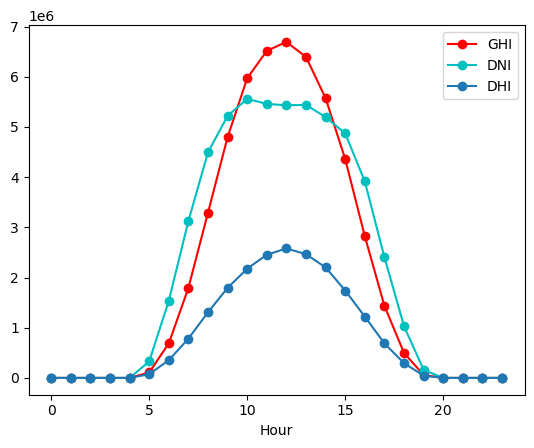

In [60]:
df = df.groupby('Hour').sum()[['GHI', 'DNI', 'DHI', b'generation']]
df[['GHI', 'DNI', 'DHI']].plot(style={'DNI': 'c-o', 'DHI': '-o', 'GHI': 'r-o'})

In [61]:
# import libraries
from alive_progress import alive_bar
import pandas as pd
import xarray as xr
import s3fs
import os

In [81]:
# s3fs is the package used to access AWS S3 buckets
# the data is public, no need for credentials
fs = s3fs.S3FileSystem(anon=True)
appended_data = []
# the data covers year from 2015 to 2059
year = 2025
# specify climate data types and attributes 
climate_type = ['solar', 'wind', 'trh']
attributes = [['dni', 'dhi'], 'windspeed_10m', ['temperature_2m', 'relativehumidity_2m']]
climate_attr_dict = {climate_type: attributes for climate_type, attributes in zip(climate_type, attributes)}
# calculate the total number in the loop
attributes_num = len(attributes)
year_num = 1
loop_total_num = year_num * attributes_num
# specify the components of the S3 URI
cloud_type = "s3://"
bucket = "nrel-pds-sup3rcc/"
folder = "conus_mriesm20_ssp585_r1i1p1f1/"
version = "v0.1.0/"
file_base = "sup3rcc_conus_mriesm20_ssp585_r1i1p1f1"
file_extension = "h5"
URI_base = os.path.join(cloud_type, bucket, folder, version, file_base)

with alive_bar(loop_total_num, force_tty=True, title='Running', length=20, bar = 'smooth') as bar:

    for climate in climate_type:
        
        URI = f"{URI_base}_{climate}_{year}.{file_extension}"
        # use `xarray` with engine `h5netcdf` to access data
        ds = xr.open_dataset(fs.open(URI), backend_kwargs={"phony_dims": "sort"}, engine='h5netcdf')

        time_index = pd.to_datetime(ds['time_index'][...].astype(str))
        meta = pd.DataFrame(ds.meta.data)
        FM_site_index = meta[(meta.county == b'Monongalia') & (meta.elevation == 318)].index[0]
        attrs = [v for k, v in climate_attr_dict.items() if climate == k][0]

        # subset the data with specified attribute, all time index, and WV Marion County index
        if climate in ['solar', 'trh']:
            for att in attrs:
                subset = ds[att][:, FM_site_index].load()
                data = pd.DataFrame({f"{att}" : subset}, index = time_index)
                appended_data.append(data)
        else:
            subset = ds[attrs][:, FM_site_index].load()
            data = pd.DataFrame({f"{attrs}" : subset}, index = time_index)
            appended_data.append(data)
        bar()

# concatenate all the data and groupby year to get the mean value
final_data = pd.concat(appended_data)

final_data

Running |████████████████████| 3/3 [100%] in 5:25.4 (0.01/s)                    


,dni,dhi,windspeed_10m,temperature_2m,relativehumidity_2m
2025-01-01 00:00:00+00:00,0.0,NaN,NaN,NaN,NaN
2025-01-01 01:00:00+00:00,0.0,NaN,NaN,NaN,NaN
2025-01-01 02:00:00+00:00,0.0,NaN,NaN,NaN,NaN
2025-01-01 03:00:00+00:00,0.0,NaN,NaN,NaN,NaN
2025-01-01 04:00:00+00:00,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-12-31 19:00:00+00:00,NaN,NaN,NaN,NaN,908800.0
2025-12-31 20:00:00+00:00,NaN,NaN,NaN,NaN,860200.0
2025-12-31 21:00:00+00:00,NaN,NaN,NaN,NaN,908400.0
2025-12-31 22:00:00+00:00,NaN,NaN,NaN,NaN,900200.0


In [91]:
final_data.rename({'dni':'dni (W/m2)', 'dhi':'dhi (W/m2)', 'windspeed_10m': 'windspeed_10m (m/s)', 'temperature_2m': 'temperature_2m (C)'}, axis=1, inplace=True)

In [93]:
final_data.drop('relativehumidity_2m', axis=1, inplace=True)
final_data['temperature_2m (C)'] = final_data['temperature_2m (C)'] / 10000
final_data['windspeed_10m (m/s)'] = final_data['windspeed_10m (m/s)'] / 10000

final_data

,dni (W/m2),dhi (W/m2),windspeed_10m (m/s),temperature_2m (C)
2025-01-01 00:00:00+00:00,0.0,NaN,NaN,NaN
2025-01-01 01:00:00+00:00,0.0,NaN,NaN,NaN
2025-01-01 02:00:00+00:00,0.0,NaN,NaN,NaN
2025-01-01 03:00:00+00:00,0.0,NaN,NaN,NaN
2025-01-01 04:00:00+00:00,0.0,NaN,NaN,NaN
...,...,...,...,...
2025-12-31 19:00:00+00:00,NaN,NaN,NaN,NaN
2025-12-31 20:00:00+00:00,NaN,NaN,NaN,NaN
2025-12-31 21:00:00+00:00,NaN,NaN,NaN,NaN
2025-12-31 22:00:00+00:00,NaN,NaN,NaN,NaN


In [94]:
final_data.groupby(final_data.index.month).mean()

,dni (W/m2),dhi (W/m2),windspeed_10m (m/s),temperature_2m (C)
1,215.235215,30.997312,3.506707,2.268750
2,192.087798,45.209821,4.133676,2.413452
3,147.419355,63.791667,3.088239,7.329597
4,111.015278,88.204167,3.804014,9.435611
5,130.211022,113.739247,2.656828,17.893790
6,124.105556,129.602778,2.501486,22.027917
7,223.788978,120.922043,1.988374,25.224637
8,188.314516,107.702957,2.441707,25.506384
9,241.152778,65.262500,2.383167,21.783708
10,179.805108,45.763441,2.399140,13.181976
